## Fraud Detection in Financial Transactions

Data source : https://www.kaggle.com/code/seuwenfei/online-payment-fraud-detection

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

### Load Input Dataset

In [40]:
# read input file containing transaction data from local directory 
inpath = r'/Users/akhilmathur/Desktop/python_files/datasets/fraud_det_data.csv'
df = pd.read_csv(inpath)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [41]:
# basic summary on data
print(f"No. of rows and columns are : {df.shape[0]}, {df.shape[1]}\n")
print(df.info())

No. of rows and columns are : 6362620, 11

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None


### Data Cleanup, Exploratory Analysis & Feature Engineering 

In [42]:
# check for missing values 
print(f"Number of null values in dataset: {df.isnull().sum().sum()}")

# check for duplicate values and delete any found
print(f"Number of duplicate values in dataset: {df.duplicated().sum()}")

Number of null values in dataset: 0
Number of duplicate values in dataset: 0


In [43]:
# lets first work with the numerical data 
df_num = df.select_dtypes(exclude = 'object')

# we remove the irrelevant columns from our dataset
drop_cols = ['step', 'isFlaggedFraud']
df_num.drop(drop_cols, axis = 'columns', inplace = True)

df_num.describe().astype(int)

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
count,6362620,6362620,6362620,6362620,6362620,6362620
mean,179861,833883,855113,1100701,1224996,0
std,603858,2888242,2924048,3399180,3674128,0
min,0,0,0,0,0,0
25%,13389,0,0,0,0,0
50%,74871,14208,0,132705,214661,0
75%,208721,107315,144258,943036,1111909,0
max,92445516,59585040,49585040,356015889,356179278,1


amount            0.077
oldbalanceOrg     0.010
newbalanceOrig   -0.008
oldbalanceDest   -0.006
newbalanceDest    0.001
isFraud           1.000
Name: isFraud, dtype: float64


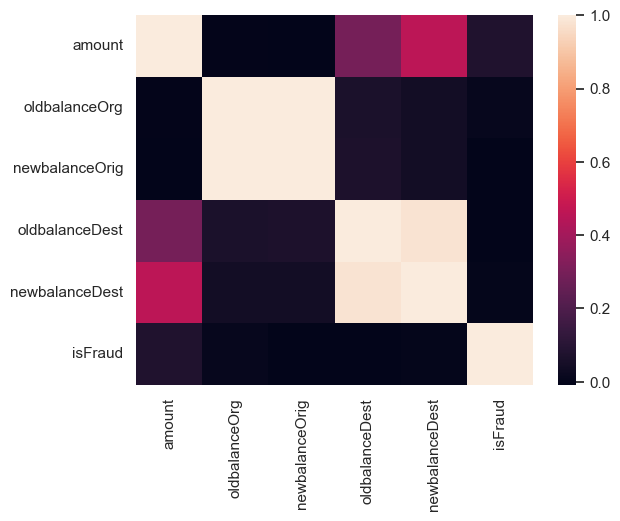

In [44]:
corr_ = df_num.corr()
sns.heatmap(corr_)

# get correlation of target variable with available features 
corr_target = corr_['isFraud'].round(3)
print(corr_target)

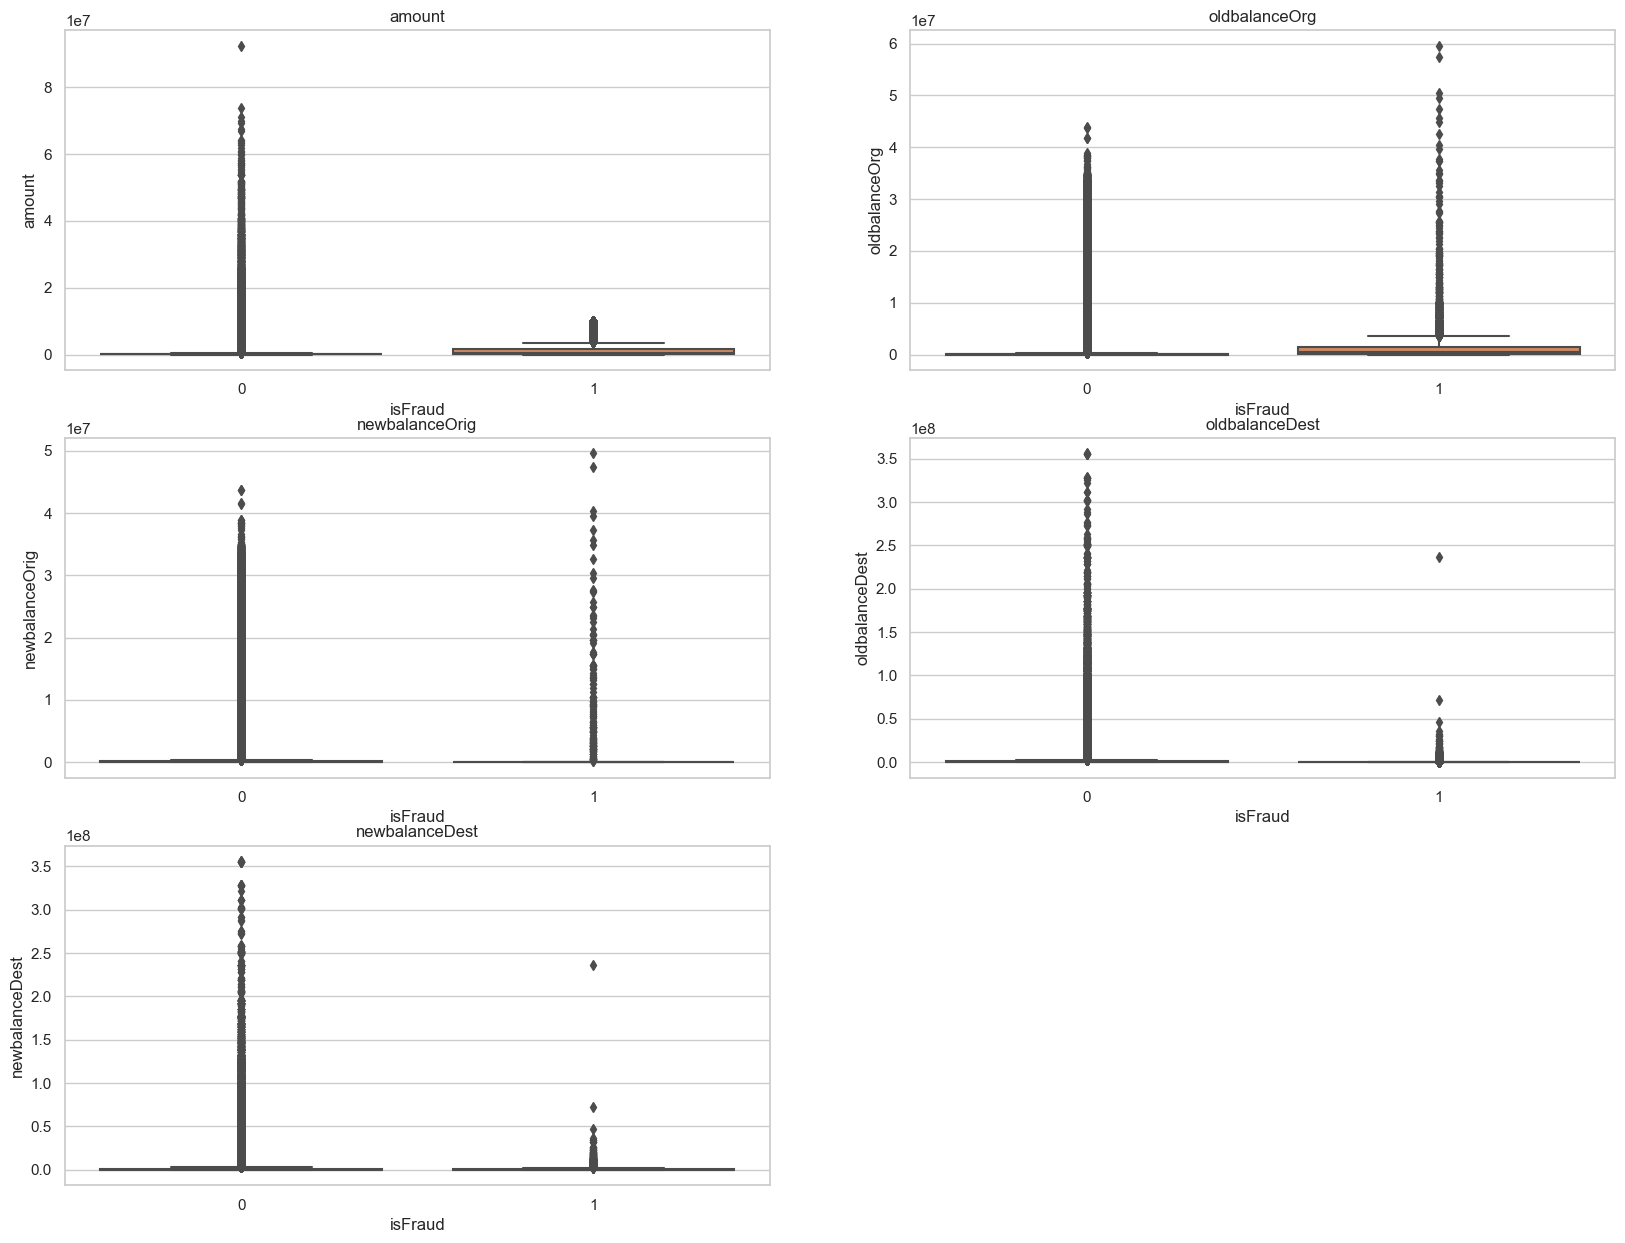

In [45]:
plt.figure(figsize=(20, 15))
sns.set(style="whitegrid")

for i, column in enumerate(df_num.columns[:-1]):  # Exclude the target column
    plt.subplot(3, len(df_num.columns)//3, i + 1)
    sns.boxplot(x='isFraud', y=column, data=df_num)
    plt.title(column)

/Users/akhilmathur/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


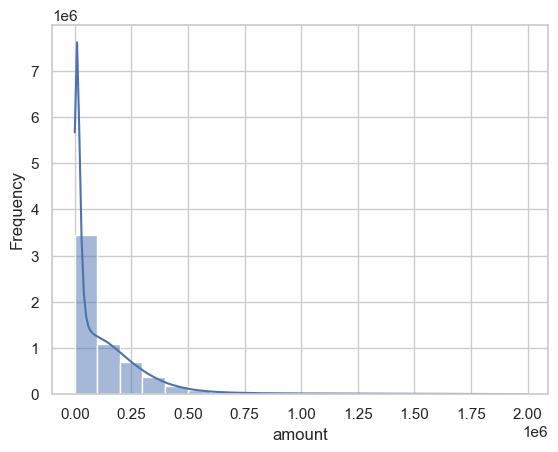

/Users/akhilmathur/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


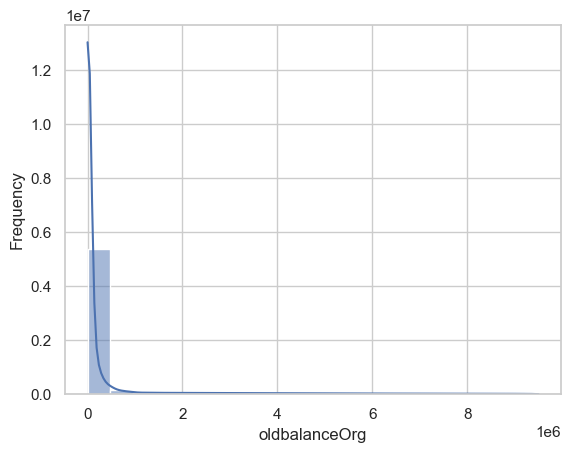

/Users/akhilmathur/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


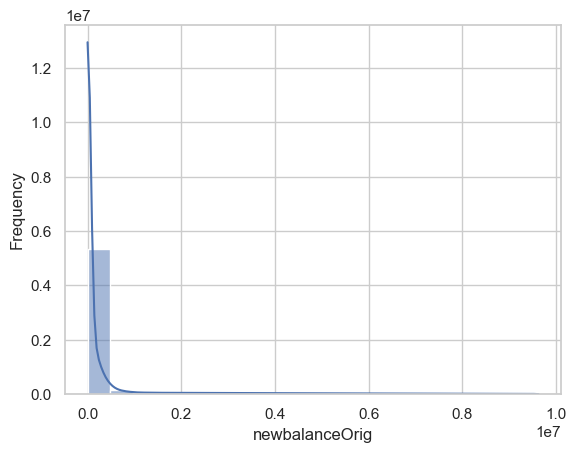

/Users/akhilmathur/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


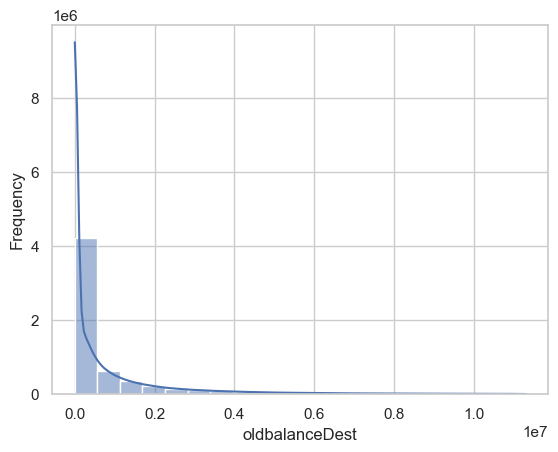

/Users/akhilmathur/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


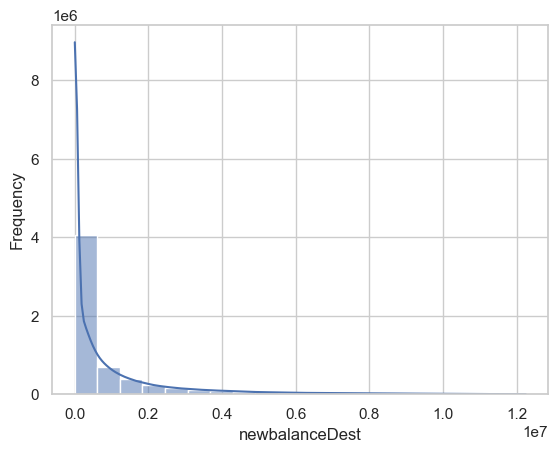

In [47]:
for i, column in enumerate(df_num.columns[:-1]):
    sns.histplot(x = df_num[column], bins=20, kde=True)
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

In [48]:
# print the skew in features data - visible in above histogram
for col_ in df_num.columns[:-1]:
    print(f"{col_}:{df_num[col_].skew().round(2)}")

# perform log transformation on the num type columns to reduce skew - exclude target variable 
for col_ in df_num.columns[:-1]:
        df_num[col_] = df_num[col_].transform(np.log1p)

# Re-check the features skew 
print("\nPost-transformation skew value:")
for col_ in df_num.columns[:-1]:
    print(f"{col_}:{df_num[col_].skew().round(2)}")

amount:3.55
oldbalanceOrg:3.99
newbalanceOrig:3.92
oldbalanceDest:3.19
newbalanceDest:3.04

Post-transformation skew value:
amount:-0.62
oldbalanceOrg:-0.28
newbalanceOrig:0.46
oldbalanceDest:-0.15
newbalanceDest:-0.33


/Users/akhilmathur/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


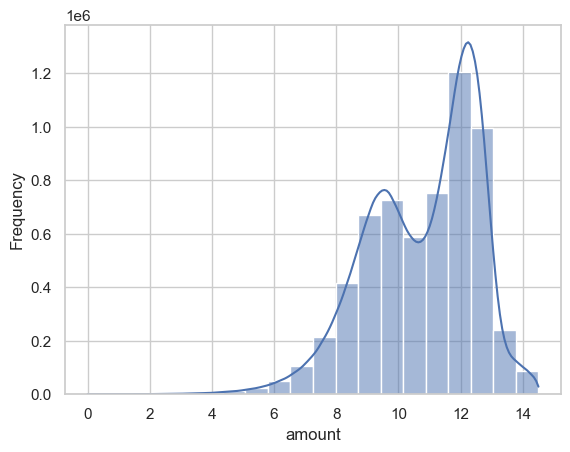

/Users/akhilmathur/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


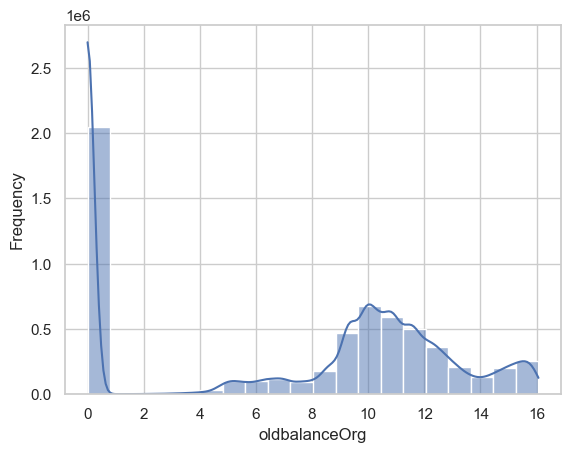

/Users/akhilmathur/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


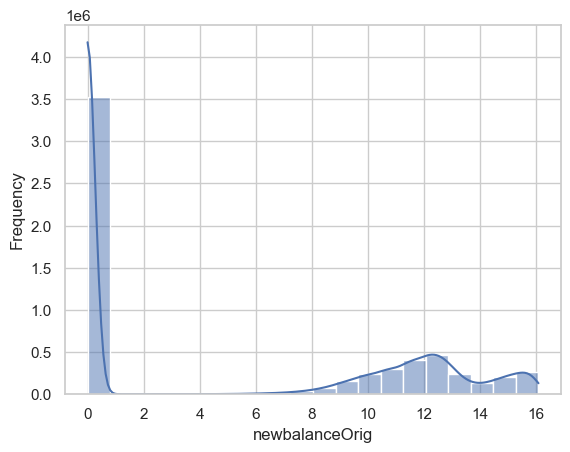

/Users/akhilmathur/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


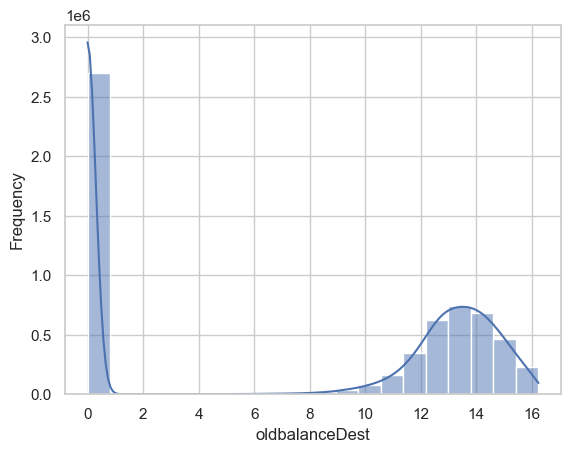

/Users/akhilmathur/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


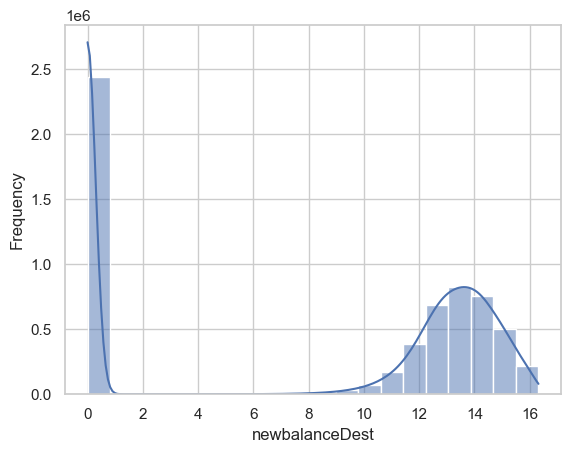

In [80]:
for i, column in enumerate(df_num.columns[:-1]):
    sns.histplot(x = df_num[column], bins=20, kde=True)
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

In [163]:
# calculate z-score and remove outliers now that the data is normally distributed (almost) 
def calc_zscore(col):
    z_score = (col - col.mean())/col.std()
    return z_score 

df_check = df_num.drop('isFraud', axis = 'columns')
df_zs = df_check.apply(calc_zscore)

df_zs['isFraud'] = df_num['isFraud']
df_num = df_num[abs(df_zs) < 3]
df_num.dropna(inplace = True)

In [51]:
# analyze categorical values 
df_cat = df.select_dtypes(include = 'object')

# get unique value count for each categorical value 
for column in df_cat:
    print(f"{column}:{df_cat[column].nunique()}")

# clearly the nameOrig and nameDest do not hold much value in terms of encoding for classification - remove them 
df_cat.drop(['nameOrig','nameDest'], axis = 'columns', inplace = True) 

df_cat_ohe = pd.get_dummies(df_cat['type'], prefix='trans_type')
df_cat_ohe = df_cat_ohe.astype(int)

df_fin = pd.merge(df_num, df_cat_ohe, left_index = True, right_index = True)

type:5
nameOrig:6353307
nameDest:2722362


In [66]:
print("Proportion of classes within target variable:\n")
df_fin['isFraud'].value_counts(normalize = True).round(3)

Proportion of classes within target variable:



isFraud
0    0.999
1    0.001
Name: proportion, dtype: float64

### Training Classification Models

In [52]:
X = df_fin.drop('isFraud', axis = 'columns')
y = df_fin['isFraud']

In [53]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state = 123)

In [170]:
from sklearn.linear_model import LogisticRegression

lr  = LogisticRegression(class_weight='balanced', penalty = 'l2', C = 0.1)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

/Users/akhilmathur/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [171]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

print("F1-Score : {}".format(f1_score(y_test,y_pred_lr, average = 'weighted').round(2)))
print("Accuracy Score : {}".format(accuracy_score(y_test,y_pred_lr).round(2)))
print("\nclassification report : \n{}".format(classification_report(y_test, y_pred_lr)))

F1-Score : 0.98
Accuracy Score : 0.95

classification report : 
              precision    recall  f1-score   support

           0       1.00      0.95      0.98   1521017
           1       0.02      0.99      0.04      1631

    accuracy                           0.95   1522648
   macro avg       0.51      0.97      0.51   1522648
weighted avg       1.00      0.95      0.98   1522648



In [68]:
# Try Random Forest Ensemble Method - works well with unbalanced classes

from sklearn.ensemble import RandomForestClassifier 
clf = RandomForestClassifier(class_weight='balanced', random_state=123) 
clf.fit(X_train, y_train) 

# predict class using testing data 
y_pred_rf = clf.predict(X_test)

In [168]:
# check results of Random Forest model 
print("F1-Score : {}".format(f1_score(y_test,y_pred_rf, average = 'weighted').round(4)))
print("Accuracy Score : {}".format(accuracy_score(y_test,y_pred_rf).round(4)))
print("\n")
print("classification report : \n{}".format(classification_report(y_test, y_pred_rf)))

F1-Score : 0.9996
Accuracy Score : 0.9997


classification report : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1521017
           1       0.96      0.71      0.82      1631

    accuracy                           1.00   1522648
   macro avg       0.98      0.86      0.91   1522648
weighted avg       1.00      1.00      1.00   1522648



In [72]:
# Try Boosting Ensemble Method 
import xgboost as xgb 

clf = xgb.XGBClassifier(objective='multi:softmax', num_class=len(set(y)))
clf.fit(X_train, y_train)
y_pred_xgb = clf.predict(X_test)

In [169]:
# check results of XGBoost model 
print("F1-Score : {}".format(f1_score(y_test,y_pred_xgb, average = 'weighted').round(4)))
print("Accuracy Score : {}".format(accuracy_score(y_test,y_pred_xgb).round(4)))
print("\n")
print("classification report : \n{}".format(classification_report(y_test, y_pred_xgb)))

F1-Score : 0.9996
Accuracy Score : 0.9996


classification report : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1521017
           1       0.91      0.71      0.80      1631

    accuracy                           1.00   1522648
   macro avg       0.95      0.86      0.90   1522648
weighted avg       1.00      1.00      1.00   1522648



In [175]:
# run k-fold cross validation with logsitic regression to check if high model accuracy is result of overfitting 

from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, balanced_accuracy_score

k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

cross_val_accuracy = cross_val_score(lr, X, y, cv=kf, scoring = make_scorer(balanced_accuracy_score))
f1_avg = cross_val_accuracy.mean().round(3)

print(f"K-Fold Cross Validation Mean Accuracy: {f1_avg}")

/Users/akhilmathur/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/akhilmathur/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

0.972


### Concluding Remarks


We were able to take our 6.3 million rows-large dataset containing transaction information, do the necessary cleanup and feature engineering to weed out outliers and trim the set of relevant features to training our supervised classification models. 

The idea was to work with a more simplistic model like Logistic Regression along with complex ensemble methods (Random Forest and Boosting) to compare their performance. Special attention had to be paid to the largely unbalanced classes (99% being negative class 0), so appropriate weights were added through hyperparameter tuning. L2 regularization was also added to prevent overfitting of model. 

We observed that both Linear Logistic Regression as well as Random Forest/XGBoost Models provided a very high accuracy of >98%. F1-score was used for evaluation metric to take into consideration both Precision and Recall of the model performance, considering the largely unbalanced classes. 

Lastly, K-fold cross validation was used with Logistic Regression to ensure the model does not overfit and generalizes well. A 5-fold Cross Validation accuracy of 97% suggests a robust classification model. Logistic Regression also provides the benefit of easier interpretibility, compared to the more complex Ensemble models. 